In [71]:
import pandas as pd

# Read columns names
columns = []
with open("adult.names") as f:
    for _, line in enumerate(f):
        line = line.strip()
        if line.startswith('|') or line == '' or (':' not in line):
            continue
            
        colname = line.split(':')[0]
        columns.append(colname)

columns.append('income')

class_names = [">50K", "<=50K"]

In [72]:
data_df = pd.read_csv("adult.data", header=None, skipinitialspace=True)
data_df.columns = columns
display(data_df.head(2))

test_df = pd.read_csv("adult.test", header=None, skiprows=1, skipinitialspace=True)
test_df.columns = columns
# Fixup income column
test_df['income'] = test_df['income'].str.rstrip('.')
display(test_df.head(2))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


In [73]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data_df['income'])
data_df['income_class'] = label_encoder.transform(data_df['income'])
test_df['income_class'] = label_encoder.transform(test_df['income'])

In [74]:
categorical_feature_names = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
numerical_feature_names = ["age", "education-num", "capital-loss", "capital-gain", "hours-per-week"]

from sklearn.preprocessing import OneHotEncoder

oh_enc = OneHotEncoder(sparse=False)
oh_enc.fit(data_df[categorical_feature_names])

X = pd.concat([data_df[numerical_feature_names], pd.DataFrame(oh_enc.transform(data_df[categorical_feature_names]), columns=oh_enc.get_feature_names(input_features=categorical_feature_names))], axis=1)
X = X.drop(X.filter(like='?', axis=1).columns, axis=1)
Xtest = pd.concat([test_df[numerical_feature_names], pd.DataFrame(oh_enc.transform(test_df[categorical_feature_names]), columns=oh_enc.get_feature_names(input_features=categorical_feature_names))], axis=1)
Xtest = Xtest.drop(Xtest.filter(like='?', axis=1).columns, axis=1)

In [123]:
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

dtrain = xgb.DMatrix(X, label=data_df["income_class"])
dtest = xgb.DMatrix(Xtest, label=test_df["income_class"])

watchlist = [(dtest, 'eval'), (dtrain, 'train')]
#xgb_model = xgb.train({"objective": "binary:hinge"}, dtrain, evals=watchlist, n_jobs=8, verbose_eval=True)
xgb_classifier = xgb.XGBClassifier(n_jobs=8, objective='binary:hinge')
xgb_classifier.fit(X, data_df["income_class"], verbose=True)
xgb_model = xgb_classifier.get_booster()

In [127]:
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK

from sklearn.metrics import roc_auc_score

def score(params):
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    xgb_model = xgb.train(params, dtrain, num_round, evals=watchlist, verbose_eval=False)
    predictions = xgb_model.predict(dtest, ntree_limit=xgb_model.best_iteration)
    gn = roc_auc_score(test_df["income_class"], np.array(predictions))
    return {'loss': 1 - gn, 'status': STATUS_OK}

space = {
        'n_estimators': hp.quniform('n_estimators', 100, 600, 1),
        'eta': hp.quniform('eta', 0.025, 0.25, 0.025), # A problem with max_depth casted to float instead of int with the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 8, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 1, 0.05),
        'alpha' :  hp.quniform('alpha', 0, 10, 1),
        'lambda': hp.quniform('lambda', 1, 2, 0.1),
        'nthread': 8,
        'objective': 'binary:logistic'
    }

trials = Trials()
best = fmin(score,
    space=space,
    algo=tpe.suggest,
    max_evals=150,
    trials=trials,
    )

#dtrain = xgb.DMatrix(X, data_df["income_class"])
#xgb_model = xgb.train({"objective": "binary:hinge"}, dtrain)

100%|██████████| 150/150 [1:31:37<00:00, 25.92s/it, best loss: 0.07089269819284927]


In [83]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    
    cm = confusion_matrix(y_true, y_pred)
    # Taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    fig = plt.figure()
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

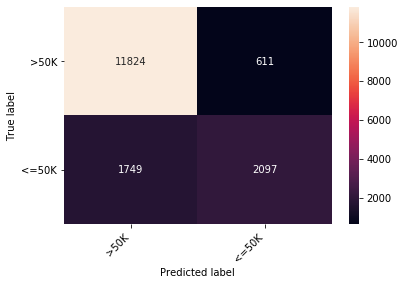

In [124]:
xgb_y_pred = pd.Series(xgb_model.predict(xgb.DMatrix(Xtest)))
plot_confusion_matrix(test_df["income_class"], xgb_y_pred, class_names)

In [125]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_df["income_class"], xgb_y_pred)
recall = recall_score(test_df["income_class"], xgb_y_pred)
f1 = f1_score(test_df["income_class"], xgb_y_pred)
print(f"Precision: {precision:.2f}, recall: {recall:2f}, F1 Score: {f1:3f}")

Precision: 0.77, recall: 0.545242, F1 Score: 0.639915


In [128]:
# consider https://github.com/facebookresearch/nevergrad/blob/master/docs/machinelearning.md

In [134]:
xgb_best_model = xgb.train({"objective": "binary:hinge", **best}, dtrain, num_boost_round=int(best["n_estimators"]), evals=watchlist, verbose_eval=True)

[0]	eval-error:0.763774	train-error:0.75919
[1]	eval-error:0.763774	train-error:0.75919
[2]	eval-error:0.763774	train-error:0.75919
[3]	eval-error:0.763774	train-error:0.75919
[4]	eval-error:0.763774	train-error:0.75919
[5]	eval-error:0.352681	train-error:0.351095
[6]	eval-error:0.277686	train-error:0.277663
[7]	eval-error:0.264419	train-error:0.264304
[8]	eval-error:0.235612	train-error:0.23565
[9]	eval-error:0.208095	train-error:0.207917
[10]	eval-error:0.197715	train-error:0.196462
[11]	eval-error:0.187335	train-error:0.184577
[12]	eval-error:0.178552	train-error:0.175394
[13]	eval-error:0.174682	train-error:0.171094
[14]	eval-error:0.170997	train-error:0.16833
[15]	eval-error:0.168724	train-error:0.164921
[16]	eval-error:0.165899	train-error:0.162311
[17]	eval-error:0.15859	train-error:0.153681
[18]	eval-error:0.148701	train-error:0.144437
[19]	eval-error:0.14563	train-error:0.142502
[20]	eval-error:0.143419	train-error:0.141212
[21]	eval-error:0.142129	train-error:0.140536
[22]	ev

Precision: 0.78, recall: 0.640666, F1 Score: 0.705310


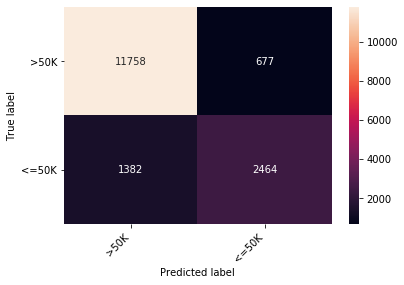

In [139]:
xgb_best_y_pred = pd.Series(xgb_best_model.predict(xgb.DMatrix(Xtest)))
plot_confusion_matrix(test_df["income_class"], xgb_best_y_pred, class_names)

precision = precision_score(test_df["income_class"], xgb_best_y_pred)
recall = recall_score(test_df["income_class"], xgb_best_y_pred)
f1 = f1_score(test_df["income_class"], xgb_best_y_pred)
print(f"Precision: {precision:.2f}, recall: {recall:2f}, F1 Score: {f1:3f}")

In [142]:
best_series = pd.Series(best)
best_series.to_csv('hyperopt_best_params.csv')

In [153]:
from sklearn.metrics import log_loss

xgb_prob = xgb.train(best, dtrain, num_boost_round=int(best["n_estimators"]), evals=watchlist, verbose_eval=False)
xgb_prob.predict(dtest)

array([-0.01797228,  0.22442713,  0.39304492, ...,  0.7055714 ,
        0.1701312 ,  0.76172704], dtype=float32)

In [166]:
log_loss(test_df["income_class"], pd.Series(xgb_best_model.predict_proba(dtest)))

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [175]:
best["n_estimators"] = int(best["n_estimators"])
xgb_proba = xgb.XGBClassifier(**best)
xgb_proba.fit(X, data_df["income_class"])

XGBClassifier(alpha=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001, eta=0.1,
              gamma=0.5, lambda=1.4000000000000001, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1.0, missing=None,
              n_estimators=139, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1.0, verbosity=1)

In [179]:
log_loss(test_df["income_class"], xgb_proba.predict_proba(Xtest))

0.27330157059258986

In [186]:
log_loss(test_df["income_class"], xgb.XGBClassifier().fit(X, data_df["income_class"], eval_set=[(Xtest, test_df["income_class"]), (X, data_df["income_class"])], verbose=False).predict_proba(Xtest))

0.29257875181985027

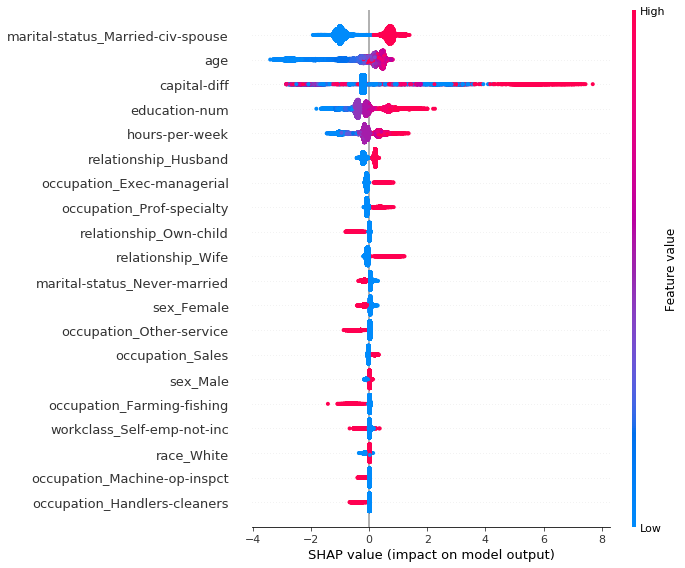

In [218]:
import shap
xgb_explainer = shap.TreeExplainer(xgb_proba)
xgb_shap_values = xgb_explainer.shap_values(X)
shap.summary_plot(xgb_shap_values, X)

0         2174
1            0
2            0
3            0
4            0
5            0
6            0
7            0
8        14084
9         5178
10           0
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22           0
23       -2042
24           0
25           0
26           0
27           0
28           0
29           0
         ...  
32531        0
32532        0
32533        0
32534        0
32535        0
32536        0
32537        0
32538    15020
32539        0
32540        0
32541        0
32542        0
32543        0
32544        0
32545        0
32546        0
32547        0
32548     1086
32549        0
32550        0
32551        0
32552        0
32553        0
32554        0
32555        0
32556        0
32557        0
32558        0
32559        0
32560    15024
Length: 32561, dtype: int64

In [216]:
xgb_proba = xgb.XGBClassifier(**best)
xgb_proba.fit(X, data_df["income_class"])

XGBClassifier(alpha=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001, eta=0.1,
              gamma=0.5, lambda=1.4000000000000001, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1.0, missing=None,
              n_estimators=139, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1.0, verbosity=1)

In [217]:
log_loss(test_df["income_class"], xgb_proba.predict_proba(Xtest))

0.27455542600030053

In [214]:
#X["capital-diff"] = X["capital-gain"] - X["capital-loss"]
#X.drop(["capital-loss", "capital-gain"], axis=1, inplace=True)

#Xtest["capital-diff"] = Xtest["capital-gain"] - Xtest["capital-loss"]
#Xtest.drop(["capital-loss", "capital-gain"], axis=1, inplace=True)

In [215]:
Xtest

,age,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,capital-diff
0,25,7,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,38,9,50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,28,12,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,44,10,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7688
4,18,10,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,34,6,30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
6,29,9,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
7,63,15,32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3103
8,24,10,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
9,55,4,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
